In [231]:
import numpy as np                                             # dense matrices
import sframe                                                  # see below for install instruction
from scipy.sparse import csr_matrix                            # sparse matrices
from scipy.sparse.linalg import norm                           # norms of sparse matrices
from sklearn.metrics.pairwise import pairwise_distances        # pairwise distances
from copy import copy                                          # deep copies
import matplotlib.pyplot as plt                                # plotting
%matplotlib inline

In [232]:
wiki = sframe.SFrame('people_wiki.gl/')
wiki = wiki.add_row_number()             # add row number, starting at 0

In [233]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix( (data, indices, indptr), shape)
    
corpus = load_sparse_csr('people_wiki_tf_idf.npz')

In [234]:
map_index_to_word = sframe.SFrame('people_wiki_map_index_to_word.gl/')

In [235]:
def generate_random_vectors(num_vectors,dim):
    return np.random.randn(dim,num_vectors)

In [236]:
np.random.seed(0)
random_vectors = generate_random_vectors(num_vectors=16,dim=547979)

In [237]:
print random_vectors.shape

(547979, 16)


In [238]:
doc = corpus[0,:]

In [239]:
index_bits = corpus.dot(random_vectors) >= 0

In [240]:
powers_of_two = (1 << np.arange(15,-1,-1))

In [241]:
print index_bits.dot(powers_of_two)

[50917 36265 19365 ..., 52983 27589 41449]


In [242]:
def train_lsh(data, num_vector=16, seed=None):
    dim = data.shape[1]
    
    if seed:
        np.random.seed(seed)

    random_vectors = generate_random_vectors(num_vector,dim)
    
    binary_indices = data.dot(random_vectors) >= 0 
    
    powers_of_two = (1 << np.arange(num_vector-1,-1,-1))
    
    int_indices = binary_indices.dot(powers_of_two)
    
    table = {}
    
    for data_index,bin_index in enumerate(int_indices):
        if bin_index not in table:
            table[bin_index] = [data_index]
        else:
            table[bin_index].append(data_index)
    
    
    model = {'data': data,
             'bin_index_bits': binary_indices,
             'bin_indices': int_indices,
             'table': table,
             'random_vectors': random_vectors,
             'num_vector': num_vector}
    return model
    

In [243]:
model = train_lsh(corpus, num_vector=16, seed=143)
table = model['table']
if   0 in table and table[0]   == [39583] and \
   143 in table and table[143] == [19693, 28277, 29776, 30399]:
    print 'Passed!'
else:
    print 'Check your code.'

Passed!


In [244]:
print wiki[wiki['name'] == 'Barack Obama']

+-------+-------------------------------+--------------+
|   id  |              URI              |     name     |
+-------+-------------------------------+--------------+
| 35817 | <http://dbpedia.org/resour... | Barack Obama |
+-------+-------------------------------+--------------+
+-------------------------------+
|              text             |
+-------------------------------+
| barack hussein obama ii br... |
+-------------------------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


In [245]:
print (corpus[35817,:].dot(random_vectors) >= 0).dot(powers_of_two)[0] # Wrong because of seed

29090


In [246]:
table[29090]

[34110]

In [247]:
#Obama bin key
for key,values in model['table'].iteritems():
    if 35817 in values:
        print key

50194


In [248]:
print wiki[wiki['name'] == 'Joe Biden']

+-------+-------------------------------+-----------+
|   id  |              URI              |    name   |
+-------+-------------------------------+-----------+
| 24478 | <http://dbpedia.org/resour... | Joe Biden |
+-------+-------------------------------+-----------+
+-------------------------------+
|              text             |
+-------------------------------+
| joseph robinette joe biden... |
+-------------------------------+
[? rows x 4 columns]
Note: Only the head of the SFrame is printed. This SFrame is lazily evaluated.
You can use sf.materialize() to force materialization.


In [249]:
(model['bin_index_bits'][35817] ^ model['bin_index_bits'][24478]).sum()

2

In [250]:
doc_ids = list(model['table'][model['bin_indices'][35817]])
doc_ids.remove(35817) # display documents other than Obama

docs = wiki.filter_by(values=doc_ids, column_name='id') # filter by id column
print docs
#It turns out that Joe Biden is much closer to Barack Obama than any of the four documents, even though Biden's bin representation differs from Obama's by 2 bits.

+-------+-------------------------------+-------------------------+
|   id  |              URI              |           name          |
+-------+-------------------------------+-------------------------+
| 21426 | <http://dbpedia.org/resour... |      Mark Boulware      |
| 39426 | <http://dbpedia.org/resour... | John Wells (politician) |
| 50261 | <http://dbpedia.org/resour... |    Francis Longstaff    |
| 53937 | <http://dbpedia.org/resour... |  Madurai T. Srinivasan  |
+-------+-------------------------------+-------------------------+
+-------------------------------+
|              text             |
+-------------------------------+
| mark boulware born 1948 is... |
| sir john julius wells born... |
| francis a longstaff born a... |
| maduraitsrinivasan is a we... |
+-------------------------------+
[4 rows x 4 columns]



In [251]:
def cosine_distance(x, y):
    xy = x.dot(y.T)
    dist = xy/(norm(x)*norm(y))
    return 1-dist[0,0]

obama_tf_idf = corpus[35817,:]
biden_tf_idf = corpus[24478,:]

print '================= Cosine distance from Barack Obama'
print 'Barack Obama - {0:24s}: {1:f}'.format('Joe Biden',
                                             cosine_distance(obama_tf_idf, biden_tf_idf))
for doc_id in doc_ids:
    doc_tf_idf = corpus[doc_id,:]
    print 'Barack Obama - {0:24s}: {1:f}'.format(wiki[doc_id]['name'],
                                                 cosine_distance(obama_tf_idf, doc_tf_idf))

================= Cosine distance from Barack Obama
Barack Obama - Joe Biden               : 0.703139
Barack Obama - Mark Boulware           : 0.950867
Barack Obama - John Wells (politician) : 0.975966
Barack Obama - Francis Longstaff       : 0.978256
Barack Obama - Madurai T. Srinivasan   : 0.993092


In [252]:
barack_obama_bits = model['bin_index_bits'][35817].dot(powers_of_two)
print barack_obama_bits

50194


In [253]:
model['bin_index_bits'][35817]
    

array([ True,  True, False, False, False,  True, False, False, False,
       False, False,  True, False, False,  True, False], dtype=bool)

In [254]:
def find_neighbours(src,rad,n_vectors):
    indexes = []
    for i in xrange(1<<n_vectors):
        matches = long(i) ^ long(src)
        if bin(matches).count("1") <= rad:
            indexes.append(i)
    return indexes

In [255]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    """
    For a given query vector and trained LSH model, return all candidate neighbors for
    the query among all bins within the given search radius.
    
    Example usage
    -------------
    >>> model = train_lsh(corpus, num_vector=16, seed=143)
    >>> q = model['bin_index_bits'][0]  # vector for the first document
  
    >>> candidates = search_nearby_bins(q, model['table'])
    """
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    # Allow the user to provide an initial set of candidates.
    candidate_set = copy(initial_candidates)
    
    query_bin_int = query_bin_bits.dot(powers_of_two)
    
    nearbybins = find_neighbours(query_bin_int,search_radius,num_vector)
    
    for nearbybin in nearbybins:
        if nearbybin in table:
            candidate_set.update(table[nearbybin])
    return candidate_set

In [256]:
obama_bin_index = model['bin_index_bits'][35817] # bin index of Barack Obama
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=0)
if candidate_set == set([35817, 21426, 53937, 39426, 50261]):
    print 'Passed test'
else:
    print 'Check your code'
print 'List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261'

Passed test
List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261


In [257]:
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=1, initial_candidates=candidate_set)
if candidate_set == set([39426, 38155, 38412, 28444, 9757, 41631, 39207, 59050, 47773, 53937, 21426, 34547,
                         23229, 55615, 39877, 27404, 33996, 21715, 50261, 21975, 33243, 58723, 35817, 45676,
                         19699, 2804, 20347]):
    print 'Passed test'
else:
    print 'Check your code'

Passed test


In [258]:
def query(vec, model, k, max_search_radius):
  
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_vector = random_vectors.shape[1]
    
    
    # Compute bin index for the query vector, in bit representation.
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    print bin_index_bits
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    candidate_set = search_nearby_bins(bin_index_bits, table, max_search_radius, initial_candidates=candidate_set)
    
    
    # Sort candidates by their true distances from the query
    nearest_neighbors = sframe.SFrame({'id':candidate_set})
    candidates = data[np.array(list(candidate_set)),:]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, metric='cosine').flatten()
    
    return nearest_neighbors.topk('distance', k, reverse=True), len(candidate_set)

In [259]:
print model['table'][35817]
print query(corpus[35817,:], model, k=10, max_search_radius=0)


[36447]
[ True  True False False False  True False False False False False  True
 False False  True False]
(Columns:
	id	int
	distance	float

Rows: 5

Data:
+-------+--------------------+
|   id  |      distance      |
+-------+--------------------+
| 35817 | -6.66133814775e-16 |
| 21426 |   0.950866757525   |
| 39426 |   0.97596600411    |
| 50261 |   0.978256163041   |
| 53937 |   0.993092148424   |
+-------+--------------------+
[5 rows x 2 columns]
, 5)


In [260]:
model

{'bin_index_bits': array([[ True,  True, False, ..., False,  True,  True],
        [False, False,  True, ..., False, False,  True],
        [ True, False,  True, ..., False, False,  True],
        ..., 
        [ True,  True, False, ...,  True,  True, False],
        [ True,  True,  True, ..., False,  True,  True],
        [False, False,  True, ...,  True, False, False]], dtype=bool),
 'bin_indices': array([53003, 10913, 46185, ..., 52070, 62355, 13108]),
 'data': <59071x547979 sparse matrix of type '<type 'numpy.float64'>'
 	with 10379283 stored elements in Compressed Sparse Row format>,
 'num_vector': 16,
 'random_vectors': array([[-0.83315434,  1.23769101, -2.47573104, ...,  0.79756606,
         -0.41435758, -0.24241533],
        [-0.65265148,  0.25670927,  0.40447313, ..., -1.42644501,
         -0.74615805,  0.51974589],
        [ 0.94565582, -0.63795808,  0.61621208, ...,  0.30495995,
         -0.96495193, -0.49425259],
        ..., 
        [-0.16295889, -0.73916065, -1.77774722,

In [261]:
import time
num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in xrange(17):
    print max_search_radius
    start=time.time()
    # Perform LSH query using Barack Obama, with max_search_radius
    result, num_candidates = query(corpus[35817,:], model, k=10,
                                   max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start  # Measure time
    
    print 'Radius:', max_search_radius
    # Display 10 nearest neighbors, along with document ID and name
    print result.join(wiki[['id', 'name']], on='id').sort('distance')
    
    # Collect statistics on 10 nearest neighbors
    average_distance_from_query = result['distance'][1:].mean()
    max_distance_from_query = result['distance'][1:].max()
    min_distance_from_query = result['distance'][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)
print average_distance_from_query_history

0
[ True  True False False False  True False False False False False  True
 False False  True False]
Radius: 0
+-------+--------------------+-------------------------+
|   id  |      distance      |           name          |
+-------+--------------------+-------------------------+
| 35817 | -6.66133814775e-16 |       Barack Obama      |
| 21426 |   0.950866757525   |      Mark Boulware      |
| 39426 |   0.97596600411    | John Wells (politician) |
| 50261 |   0.978256163041   |    Francis Longstaff    |
| 53937 |   0.993092148424   |  Madurai T. Srinivasan  |
+-------+--------------------+-------------------------+
[5 rows x 3 columns]

1
[ True  True False False False  True False False False False False  True
 False False  True False]
Radius: 1
+-------+--------------------+-------------------------------+
|   id  |      distance      |              name             |
+-------+--------------------+-------------------------------+
| 35817 | -6.66133814775e-16 |          Barack Obama  

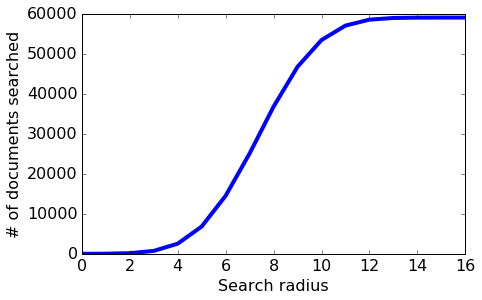

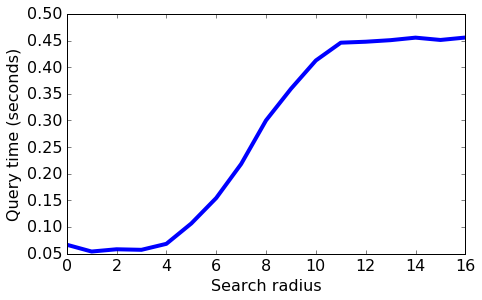

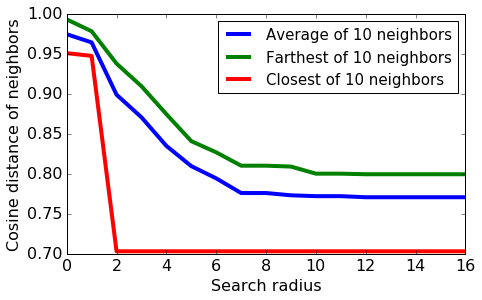

In [262]:
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [263]:
def brute_force_query(vec, data, k):
    num_data_points = data.shape[0]
    
    # Compute distances for ALL data points in training set
    nearest_neighbors = sframe.SFrame({'id':range(num_data_points)})
    nearest_neighbors['distance'] = pairwise_distances(data, vec, metric='cosine').flatten()
    
    return nearest_neighbors.topk('distance', k, reverse=True)

In [264]:
max_radius = 17
precision = {i:[] for i in xrange(max_radius)}
average_distance  = {i:[] for i in xrange(max_radius)}
query_time  = {i:[] for i in xrange(max_radius)}

np.random.seed(0)
num_queries = 10
for i, ix in enumerate(np.random.choice(corpus.shape[0], num_queries, replace=False)):
    print('%s / %s' % (i, num_queries))
    ground_truth = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors
    
    for r in xrange(1,max_radius):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=r)
        end = time.time()

        query_time[r].append(end-start)
        # precision = (# of neighbors both in result and ground_truth)/10.0
        precision[r].append(len(set(result['id']) & ground_truth)/10.0)
        average_distance[r].append(result['distance'][1:].mean())

0 / 10
[False False  True False False  True  True  True False  True  True False
  True  True  True False]
[False False  True False False  True  True  True False  True  True False
  True  True  True False]
[False False  True False False  True  True  True False  True  True False
  True  True  True False]
[False False  True False False  True  True  True False  True  True False
  True  True  True False]
[False False  True False False  True  True  True False  True  True False
  True  True  True False]
[False False  True False False  True  True  True False  True  True False
  True  True  True False]
[False False  True False False  True  True  True False  True  True False
  True  True  True False]
[False False  True False False  True  True  True False  True  True False
  True  True  True False]
[False False  True False False  True  True  True False  True  True False
  True  True  True False]
[False False  True False False  True  True  True False  True  True False
  True  True  True False]
[Fa

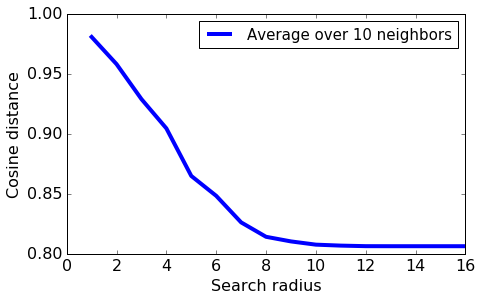

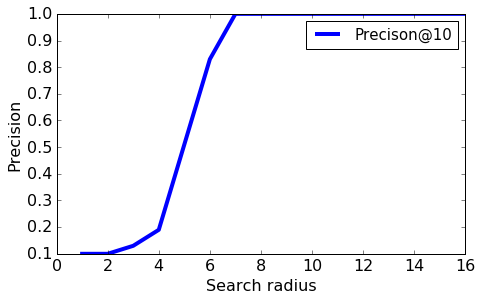

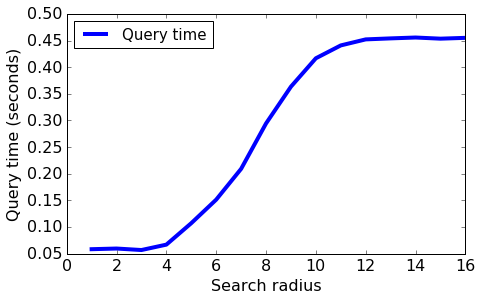

In [265]:
plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(average_distance[i]) for i in xrange(1,17)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(precision[i]) for i in xrange(1,17)], linewidth=4, label='Precison@10')
plt.xlabel('Search radius')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(1,17), [np.mean(query_time[i]) for i in xrange(1,17)], linewidth=4, label='Query time')
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [266]:
precision = {i:[] for i in xrange(5,20)}
average_distance  = {i:[] for i in xrange(5,20)}
query_time = {i:[] for i in xrange(5,20)}
num_candidates_history = {i:[] for i in xrange(5,20)}
ground_truth = {}

np.random.seed(0)
num_queries = 10
docs = np.random.choice(corpus.shape[0], num_queries, replace=False)

for i, ix in enumerate(docs):
    ground_truth[ix] = set(brute_force_query(corpus[ix,:], corpus, k=25)['id'])
    # Get the set of 25 true nearest neighbors

for num_vector in xrange(5,20):
    print('num_vector = %s' % (num_vector))
    model = train_lsh(corpus, num_vector, seed=143)
    
    for i, ix in enumerate(docs):
        start = time.time()
        result, num_candidates = query(corpus[ix,:], model, k=10, max_search_radius=3)
        end = time.time()
        
        query_time[num_vector].append(end-start)
        precision[num_vector].append(len(set(result['id']) & ground_truth[ix])/10.0)
        average_distance[num_vector].append(result['distance'][1:].mean())
        num_candidates_history[num_vector].append(num_candidates)

num_vector = 5
[False False False False  True]
[ True False  True  True  True]
[ True  True False  True  True]
[ True  True False False False]
[False  True  True False False]
[ True  True  True False False]
[False  True False  True  True]
[False  True False  True  True]
[ True  True  True False False]
[False  True False False  True]
num_vector = 6
[ True  True False  True  True  True]
[False False  True  True False False]
[ True False False  True  True False]
[False False False  True  True False]
[False  True False False False  True]
[ True  True False  True False False]
[ True  True  True  True  True False]
[False  True  True  True False False]
[False False False  True  True False]
[False  True  True  True False False]
num_vector = 7
[ True False False  True  True False False]
[False  True False False  True False False]
[ True  True  True False False  True  True]
[False  True False  True False  True  True]
[ True False False  True False False False]
[False  True  True  True False Fals

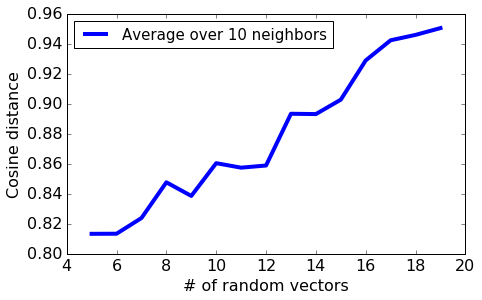

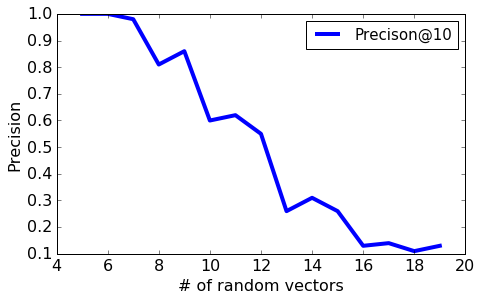

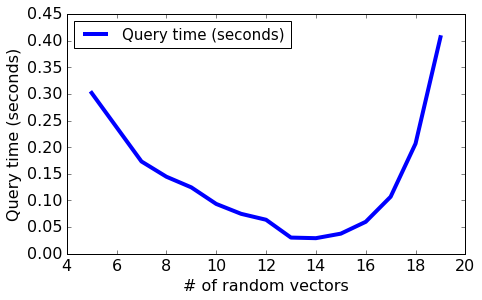

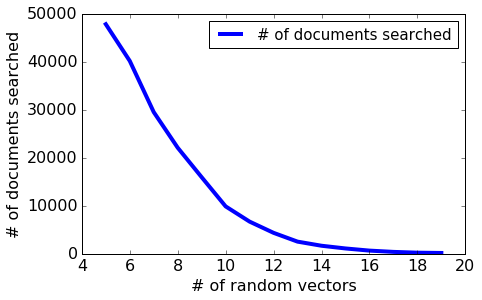

In [267]:
plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(average_distance[i]) for i in xrange(5,20)], linewidth=4, label='Average over 10 neighbors')
plt.xlabel('# of random vectors')
plt.ylabel('Cosine distance')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(precision[i]) for i in xrange(5,20)], linewidth=4, label='Precison@10')
plt.xlabel('# of random vectors')
plt.ylabel('Precision')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(query_time[i]) for i in xrange(5,20)], linewidth=4, label='Query time (seconds)')
plt.xlabel('# of random vectors')
plt.ylabel('Query time (seconds)')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(range(5,20), [np.mean(num_candidates_history[i]) for i in xrange(5,20)], linewidth=4,
         label='# of documents searched')
plt.xlabel('# of random vectors')
plt.ylabel('# of documents searched')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [268]:
model = train_lsh(corpus, 19, seed=143)